# Include

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 13.0 MB/s eta 0:00:00


In [ ]:
!pip install counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for counter: filename=Counter-1.0.0-py3-none-any.whl size=5408 sha256=7a03688bb57c129debb0e6425ab74c7523aff1e1036f79db755964fa63627e88
  Stored in directory: /root/.cache/pip/wheels/8c/53/bd/a2a81742d0585769e6f7304ccafdd9d85b828371602b103728
Successfully built counter


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import re
import folium
import json
from folium.plugins import HeatMap
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
import geopandas
from collections import Counter

# Open DF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/My Drive/data/data1.csv", sep=";")
df.shape

(1020095, 9)

In [ ]:
df.head()

fsq_id        swm_id  \
0  4cc043410cc4b713ad3cedf7  1.382012e+09   
1  57d4a224cd10ffc104e9b8c2  7.424768e+07   
2  6136525917ce7a2afe7f16bc  5.019683e+06   
3  4bbbd0392d9ea593dff39fce  1.350529e+08   
4  4d779ee18963f04d21e9ee37  9.268453e+07   

                                        name              categorie country  \
0                                      梅田出入口             Toll Booth      JP   
1                               炉端肉焼き処猛伸 たけし              BBQ Joint      JP   
2                           The Blind Rabbit                    Bar      GB   
3                                     北山田交差点  Public Transportation      JP   
4  Migros Ataköy Konakları - Ataköy Plus Avm       Department Store      TR   

         city                         timestamp   latitude   longitude  
0       Osaka  2022-05-19 21:44:12.415195+09:00  34.700761  135.491450  
1     Fukuoka  2022-05-19 21:44:14.307749+09:00  33.595423  130.411645  
2  Nottingham  2022-05-19 13:44:18.364958+01:00  52.951511   -1.145812  
3    Yokohama  2022-05-19 21:44:35.349549+09:00  35.562375  139.588050  
4    Bakırköy  2022-05-19 15:44:40.513704+03:00  40.978529   28.850354

## Define data type and drop rows with error

In [ ]:
df["latitude"] = pd.to_numeric(df["latitude"], errors='coerce') # typecast string para numerico
df["longitude"] = pd.to_numeric(df["longitude"], errors='coerce') # typecast string para numerico
df['swm_id'] = df['swm_id'].astype(str)
df = df[df["name"].str.contains("0") == False] # selecionando todas as linhas que não possuem "0" em name
df = df.dropna(axis=0, how='any') # drop do index antigo
df = df.reset_index() # resetando o index
del df['index'] # deletando coluna index
df['venue_weight'] = df['fsq_id'].map(df['fsq_id'].value_counts()) # add column weight
df["categorie"] = df["categorie"].apply(lambda x: x.replace("\\/", "/"))
df.head()

fsq_id        swm_id  \
0  4cc043410cc4b713ad3cedf7  1382011868.0   
1  57d4a224cd10ffc104e9b8c2    74247679.0   
2  6136525917ce7a2afe7f16bc     5019683.0   
3  4bbbd0392d9ea593dff39fce   135052880.0   
4  4d779ee18963f04d21e9ee37    92684528.0   

                                        name              categorie country  \
0                                      梅田出入口             Toll Booth      JP   
1                               炉端肉焼き処猛伸 たけし              BBQ Joint      JP   
2                           The Blind Rabbit                    Bar      GB   
3                                     北山田交差点  Public Transportation      JP   
4  Migros Ataköy Konakları - Ataköy Plus Avm       Department Store      TR   

         city                         timestamp   latitude   longitude  \
0       Osaka  2022-05-19 21:44:12.415195+09:00  34.700761  135.491450   
1     Fukuoka  2022-05-19 21:44:14.307749+09:00  33.595423  130.411645   
2  Nottingham  2022-05-19 13:44:18.364958+01:00  52.951511   -1.145812   
3    Yokohama  2022-05-19 21:44:35.349549+09:00  35.562375  139.588050   
4    Bakırköy  2022-05-19 15:44:40.513704+03:00  40.978529   28.850354   

   venue_weight  
0            17  
1             2  
2             2  
3             2  
4             6

In [ ]:
#Counter(list(df["city"][df['country'] != 'JP'].values))
#df['venue_weight'][df['categorie'] == 'Bar'].sum()
#df['city'].value_counts()["Tokyo"]
#df[df["city"]=="Tokyo"].shape
#df["categorie"]
#df.shape

In [ ]:
venues = df.drop_duplicates(subset='fsq_id', inplace=False, keep='first')

# Categories

### Abrindo arquivo categorias

In [ ]:
# https://github.com/Factual/places/blob/master/categories/integrated_places_files/foursquare_to_integrated.json
# https://github.com/Factual/places/blob/master/categories/integrated_places_files/factual_to_integrated.json

with open('/content/drive/My Drive/data/new_cat.json') as json_file:
    data1 = json.load(json_file)

## Create dictionary to get full label from the categories

In [ ]:
dining = []; dining_cat = []; macro = []; category = []

for i in tqdm(data1, total=len(data1)):
    try:
      fsq_label = data1[str(i)]['foursquare_label'].split('>')
      macro.append(fsq_label[0].strip())
      category.append(fsq_label[len(fsq_label)-1].strip())
      splitted = data1[str(i)]['single_match']['integrated_category_label'].split('>')
      if splitted[0].strip() == "Dining and Drinking": 
        dining.append(splitted[1].strip())
        dining_cat.append(splitted[len(splitted)-1].strip())
      macro.append(splitted[0].strip())
      category.append(splitted[len(splitted)-1].strip())
    except:
      splitted = data1[str(i)]['single_match']['integrated_category_label'].split('>')
      macro.append(splitted[0].strip())
      category.append(splitted[len(splitted)-1].strip())

my_dict = dict(zip(category,macro))
dining_dict = dict(zip(dining_cat,dining))

  0%|          | 0/1452 [00:00<?, ?it/s]

In [ ]:
my_dict['Golf Store'] = 'Retail'

my_dict['Hair Salon'] = 'Business and Professional Services' 
my_dict['Barbershop'] = 'Business and Professional Services' 
my_dict['Photographer'] = 'Business and Professional Services' 

my_dict['University Tunku Abdul Rahman'] = 'Community and Government'
my_dict['Research Laboratory'] = 'Community and Government'

my_dict['Surf Store'] = 'Sports and Recreation'
my_dict['Soccer Club'] = 'Sports and Recreation'
my_dict['American Family Fitness- Corporate'] = 'Sports and Recreation'
my_dict['Soccer Match'] = 'Sports and Recreation'
my_dict['Martial Arts School'] = 'Sports and Recreation'

my_dict['Airport Ticket Counter'] = 'Travel and Transportation'

my_dict['Stables'] = 'Landmarks and Outdoors'

my_dict['Movie'] = 'Arts & Entertainment' 
my_dict['Concert'] = 'Arts & Entertainment' 

my_dict['Healthcare Clinic'] = 'Health and Medicine' 
my_dict['Pathology Branch Of US CDC'] = 'Health and Medicine'
my_dict['Irwin Animal Hospital'] = 'Health and Medicine'

dining_dict['Dining and Drinking'] = 'Restaurant'
dining_dict['Salad Place'] = 'Restaurant'
dining_dict['Pizza Place'] = 'Restaurant'
dining_dict['Deli / Bodega'] = 'Restaurant'
dining_dict['Poke Place'] = 'Restaurant'
dining_dict['Noodle House'] = 'Restaurant'
dining_dict['Taco Place'] = 'Restaurant'
dining_dict['Burrito Place'] = 'Restaurant'
dining_dict['Sandwich Place'] = 'Restaurant'
dining_dict['Vegetarian / Vegan Restaurant'] = 'Restaurant'
dining_dict['Soup Place'] = 'Restaurant'

dining_dict['Irish Pub'] = 'Bar'
dining_dict['Nightclub'] = 'Bar'
dining_dict['Other Nightlife'] = 'Bar'

dining_dict['Ice Cream Shop'] = 'Dessert Shop'

In [ ]:
atoa = []
dif = []

for i in tqdm(df['categorie'], total=len(df)):
    try:
        atoa.append(my_dict[i])
    except:
        dif.append(i)

  0%|          | 0/986393 [00:00<?, ?it/s]

## Categories equivalence
 - Arts and Entertainment -> 0
 - Business and Professional Services -> 1
 - Community and Government -> 2
 - Dining and Drinking -> 3
 - Event -> 4
 - Health and Medicine -> 5
 - Landmarks and Outdoors -> 6
 - Retail -> 7
 - Sports and Recreation -> 8
 - Travel and Transportation -> 9
 - Residence -> 10

In [ ]:
macro_venues = []

for i in tqdm(df['categorie'], total=len(df)):
  try:
    #macro_venues.append(my_dict[i].strip())
    if my_dict[i] == 'Arts and Entertainment' or my_dict[i] == 'Arts & Entertainment': macro_venues.append(0)
    elif my_dict[i] == 'Business and Professional Services' or my_dict[i] == 'Professional & Other Places': macro_venues.append(1)
    elif my_dict[i] == 'Community and Government' or my_dict[i] == 'College & University': macro_venues.append(2)
    elif my_dict[i] == 'Dining and Drinking' or my_dict[i] == 'Nightlife Spot' or my_dict[i] == 'Food': macro_venues.append(3)
    elif my_dict[i] == 'Event': macro_venues.append(4)
    elif my_dict[i] == 'Health and Medicine': macro_venues.append(5)
    elif my_dict[i] == 'Landmarks and Outdoors' or my_dict[i] == 'Outdoors & Recreation': macro_venues.append(6)
    elif my_dict[i] == 'Retail' or my_dict[i] == 'Shop & Service': macro_venues.append(7)
    elif my_dict[i] == 'Sports and Recreation': macro_venues.append(8)
    elif my_dict[i] == 'Travel and Transportation' or my_dict[i] == 'Travel & Transport': macro_venues.append(9)
    elif my_dict[i] == 'Residence': macro_venues.append(10)
  except:
    macro_venues.append(np.nan)
    
'''venues['classification'] = macro_venues
venues = venues.dropna()
venues.reset_index(drop=True)'''

df['classification'] = macro_venues
df = df.dropna()
df.reset_index(drop=True)

  0%|          | 0/986393 [00:00<?, ?it/s]

fsq_id        swm_id  \
0       4cc043410cc4b713ad3cedf7  1382011868.0   
1       57d4a224cd10ffc104e9b8c2    74247679.0   
2       6136525917ce7a2afe7f16bc     5019683.0   
3       4bbbd0392d9ea593dff39fce   135052880.0   
4       4d779ee18963f04d21e9ee37    92684528.0   
...                          ...           ...   
985656  514e6029e4b06c69f31c9ab0   167006340.0   
985657  55bf0dc9498e7127c03f6ba7  1373827739.0   
985658  4cbac1ae4352a1cd5bef94f5    43452682.0   
985659  4c106a7c3ce120a1c624081c    55549627.0   
985660  50726a4de4b0ec75e7146a7f   117696070.0   

                                             name  \
0                                           梅田出入口   
1                                    炉端肉焼き処猛伸 たけし   
2                                The Blind Rabbit   
3                                          北山田交差点   
4       Migros Ataköy Konakları - Ataköy Plus Avm   
...                                           ...   
985656                                    相模原愛川IC   
985657    Chiba University Faculty of Engineering   
985658                                 中華そば 寅 柄沢店   
985659                              CoCo壱番屋 鶴岡道形店   
985660                               LOFT 甲府昭和ロフト   

                           categorie country        city  \
0                         Toll Booth      JP       Osaka   
1                          BBQ Joint      JP     Fukuoka   
2                                Bar      GB  Nottingham   
3              Public Transportation      JP    Yokohama   
4                   Department Store      TR    Bakırköy   
...                              ...     ...         ...   
985656                    Toll Booth      JP        相模原市   
985657  College Engineering Building      JP         千葉市   
985658              Ramen Restaurant      JP         藤沢市   
985659     Japanese Curry Restaurant      JP         鶴岡市   
985660            Miscellaneous Shop      JP         昭和町   

                               timestamp   latitude   longitude  venue_weight  \
0       2022-05-19 21:44:12.415195+09:00  34.700761  135.491450            17   
1       2022-05-19 21:44:14.307749+09:00  33.595423  130.411645             2   
2       2022-05-19 13:44:18.364958+01:00  52.951511   -1.145812             2   
3       2022-05-19 21:44:35.349549+09:00  35.562375  139.588050             2   
4       2022-05-19 15:44:40.513704+03:00  40.978529   28.850354             6   
...                                  ...        ...         ...           ...   
985656  2022-07-26 11:43:44.123777+09:00  35.527041  139.360504            41   
985657  2022-07-26 11:43:45.110315+09:00  35.626230  140.103289             6   
985658  2022-07-26 11:43:48.268534+09:00  35.348949  139.495443             5   
985659  2022-07-26 11:43:50.102373+09:00  38.743788  139.842677             4   
985660  2022-07-26 11:43:55.124952+09:00  35.640303  138.543307             4   

        classification  
0                  9.0  
1                  3.0  
2                  3.0  
3                  9.0  
4                  7.0  
...                ...  
985656             9.0  
985657             2.0  
985658             3.0  
985659             3.0  
985660             7.0  

[985661 rows x 11 columns]

### Create dict to get classification name by number

In [ ]:
labels = ['Arts and Entertainment','Business and Professional Services','Community and Government','Dining and Drinking','Event','Health and Medicine','Landmarks and Outdoors','Retail','Sports and Recreation','Travel and Transportation','Residence']
indexes = [0,1,2,3,4,5,6,7,8,9,10]

classification = dict(zip(indexes,labels))

# CLUSTERING


## Defining City

In [ ]:
city = 'Tokyo'
venues_city = df.iloc[:,[5,7,8]]
venues_city = venues_city[venues_city['city'] == city].iloc[:,[1,2]]
venues_city = venues_city[venues_city['latitude'] > 10] # Tokyo
venues_city.shape

## CATEGORY
city_cat = df.iloc[:,[5,7,8,10]]
city_cat = city_cat[city_cat['city'] == city].iloc[:,[1,2,3]]
city_cat = city_cat[city_cat['latitude'] > 10] # Tokyo
city_cat.shape

(17304, 3)

## Defining timestamp

In [ ]:
### Create dict with dates and weekdays ###
dates = []; weekdays = []; time = []
for i in tqdm(list(df['timestamp'].values), total=len(df)):
  dates.append(i.split(' ')[0])
  if pd.Timestamp(i.split(' ')[0]).dayofweek < 5: weekdays.append(1)
  else: weekdays.append(0)
  aux = i.split(' ')[1].split('.')[0] #time.append(i.split(' ')[0])
  if   aux >= '00:00:00' and aux <= '05:59:59': time.append(0)
  elif aux >= '06:00:00' and aux <= '11:59:59': time.append(1)
  elif aux >= '12:00:00' and aux <= '17:59:59': time.append(2)
  elif aux >= '18:00:00' and aux <= '23:59:59': time.append(3)

dates = list(Counter(dates).keys())

weekday = []
for i in tqdm(dates, total=len(dates)):
  if pd.Timestamp(i).dayofweek < 5: weekday.append(1)
  else: weekday.append(0)

date = dict(zip(dates,weekday))

  0%|          | 0/985661 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#venues_time = venues.iloc[:,[3,5,6,7,8,9,10,11,12]]
#venues_time = df
df['weekday'] = weekdays
df['time'] = time
#venues_time = venues_time[venues_time['country'] == country_ab].iloc[:,[1,2]]
df.shape

(985661, 13)

## DBSCAN

### City (no category)

In [ ]:
db = DBSCAN(eps=0.02, min_samples=10).fit(venues_city.iloc[:,[0,1]]) ### NY -> eps=0.05       Tokyo -> eps=0.2
labels_city_db = db.labels_
venues_city['dbscan'] = labels_city_db

# Number of clusters in labels, ignoring noise if present.
n_clusters_city_db = len(set(labels_city_db)) - (1 if -1 in labels_city_db else 0)
n_noise_city_db = list(labels_city_db).count(-1)

print("Estimated number of clusters: %d" % n_clusters_city_db)
print("Estimated number of noise points: %d" % n_noise_city_db)

Estimated number of clusters: 4
Estimated number of noise points: 8


### City (category)

In [ ]:
db = DBSCAN(eps=0.05, min_samples=10).fit(city_cat)
labels_city_category_db = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_city_category_db = len(set(labels_city_category_db)) - (1 if -1 in labels_city_category_db else 0)
n_noise_city_category_db = list(labels_city_category_db).count(-1)

print("Estimated number of clusters: %d" % n_clusters_city_category_db)
print("Estimated number of noise points: %d" % n_noise_city_category_db)

Estimated number of clusters: 12
Estimated number of noise points: 50


## KMEANS

### City (no category)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

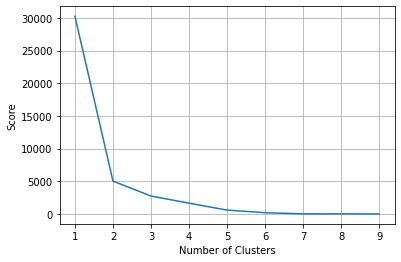

In [ ]:
wcss = []
for i in range(1, 10):
  #print(i)
  kmeans = KMeans(n_clusters=i, random_state=10)
  kmeans.fit(venues_city)
  wcss.append(kmeans.inertia_)

#plt.style.use("fivethirtyeight")
plt.plot(range(1, 10), wcss)
plt.xticks(range(1, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.grid()
plt.show()

In [ ]:
nclusters = 4
kmeans = KMeans(n_clusters = nclusters, init ='k-means++')
kmeans.fit(venues_city[venues_city.columns[0:2]]) # Compute k-means clustering.
venues_city['k-means'] = kmeans.fit_predict(venues_city[venues_city.columns[0:2]])
centers_city = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels_city = kmeans.predict(venues_city[venues_city.columns[0:2]]) # Labels of each point

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### City (category)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

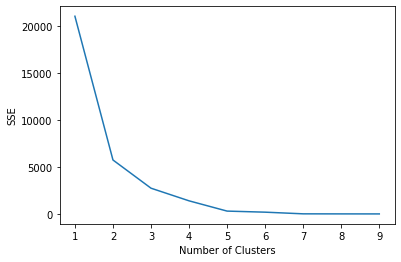

In [ ]:
wcss = []
for i in range(1, 10):
  #print(i)
  kmeans = KMeans(n_clusters=i, random_state=10)
  kmeans.fit(venues_city)
  wcss.append(kmeans.inertia_)

#plt.style.use("fivethirtyeight")
plt.plot(range(1, 10), wcss)
plt.xticks(range(1, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = nclusters, init ='k-means++')
kmeans.fit(city_cat[city_cat.columns[0:3]]) # Compute k-means clustering.
city_cat['kmeans'] = kmeans.fit_predict(city_cat[city_cat.columns[0:3]])
centers_city_category = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels_city_category = kmeans.predict(city_cat[city_cat.columns[0:3]]) # Labels of each point

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Cluster Results


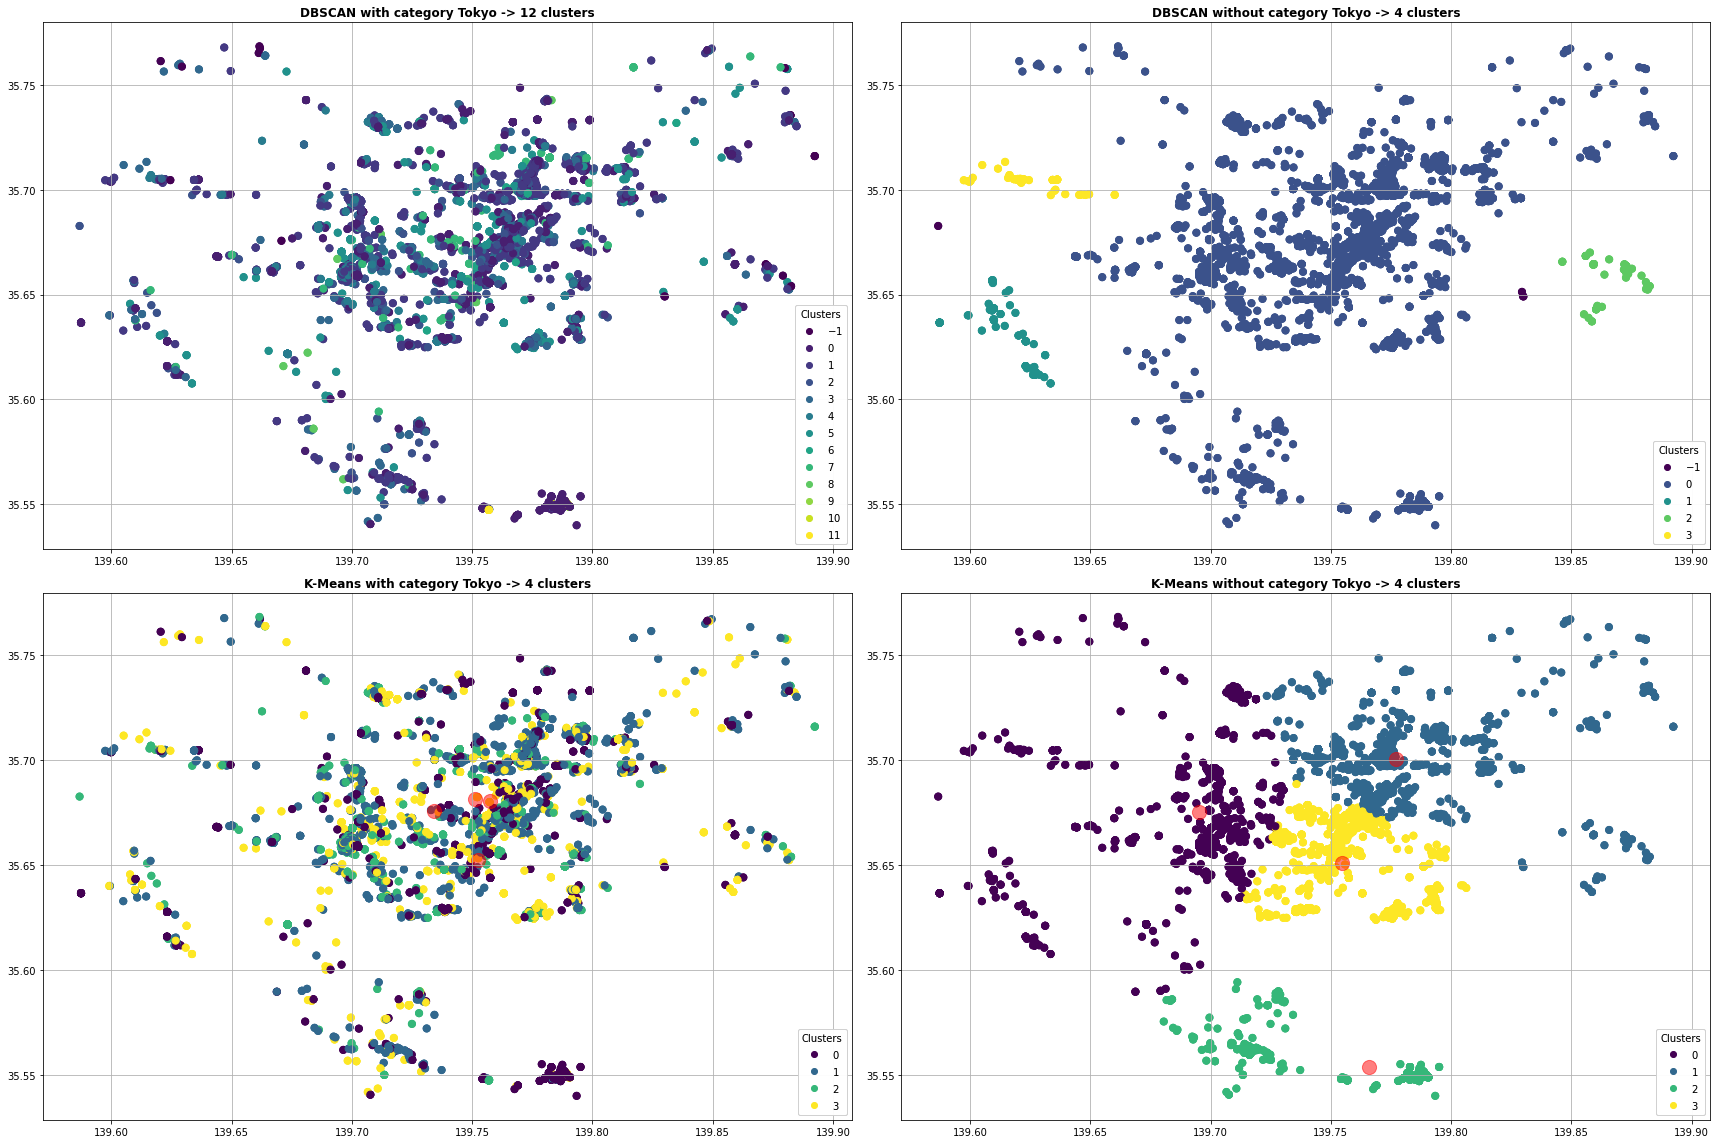

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(24,16))

### DBSCAN
scatter = ax[0][0].scatter(venues_city['longitude'], venues_city['latitude'], c=labels_city_category_db, s=50, cmap='viridis')
ax[0][0].set_title(f'DBSCAN with category {city} -> {n_clusters_city_category_db} clusters', fontweight="bold")
legend = ax[0][0].legend(*scatter.legend_elements(), loc="lower right", title="Clusters")
ax[0][0].add_artist(legend)
ax[0][0].grid()

scatter1 = ax[0][1].scatter(venues_city['longitude'], venues_city['latitude'], c=labels_city_db, s=50, cmap='viridis')
ax[0][1].set_title(f'DBSCAN without category {city} -> {n_clusters_city_db} clusters', fontweight="bold")
legend1 = ax[0][1].legend(*scatter1.legend_elements(), loc="lower right", title="Clusters")
ax[0][1].add_artist(legend1)
ax[0][1].grid()

### KMEANS
scatter2 = ax[1][0].scatter(city_cat['longitude'], city_cat['latitude'], c=labels_city_category, s=50, cmap='viridis')
ax[1][0].scatter(centers_city_category[:, 1], centers_city_category[:, 0], c='red', s=200, alpha=0.5)
ax[1][0].set_title(f'K-Means with category {city} -> {nclusters} clusters', fontweight="bold")
legend2 = ax[1][0].legend(*scatter2.legend_elements(), loc="lower right", title="Clusters")
ax[1][0].add_artist(legend2)
ax[1][0].grid()

scatter3 = ax[1][1].scatter(venues_city['longitude'], venues_city['latitude'], c=labels_city, s=50, cmap='viridis')
ax[1][1].scatter(centers_city[:, 1], centers_city[:, 0], c='red', s=200, alpha=0.5)
ax[1][1].set_title(f'K-Means without category {city} -> {nclusters} clusters', fontweight="bold")
legend3 = ax[1][1].legend(*scatter3.legend_elements(), loc="lower right", title="Clusters")
ax[1][1].add_artist(legend3)
ax[1][1].grid()

plt.tight_layout()
plt.show()

### .gpkg

In [ ]:
path = geopandas.datasets.get_path('nybb')
ny = geopandas.read_file(path)
ny = ny.to_crs(epsg=4326)
tk = geopandas.read_file("/content/drive/My Drive/data/gadm36_JPN.gpkg")
tk = tk[tk['NAME_1'] == 'Tokyo']
tk = tk.reset_index(drop=True)
t = [0,3,4,5,7,8,20,21,22,27,28,31,32,33,36,37,38,42,43,44,45,46,47,48,50,52]

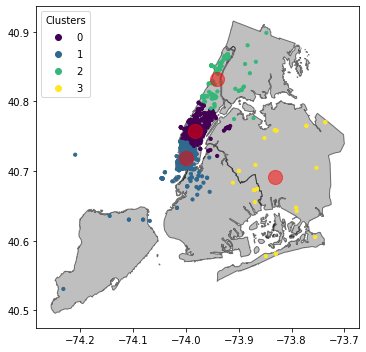

In [ ]:

#ny.boundary.plot(figsize=(6,5), color='gray', alpha=0.5)
ny.plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')
#tk.iloc[t,:].plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')
scatter = plt.scatter(venues_city['longitude'], venues_city['latitude'], c=labels_city, s=10, cmap='viridis', alpha=1)
scatter2= plt.scatter(centers_city[:, 1], centers_city[:, 0], c='red', s=200, alpha=0.5) # K-Means
legend = plt.legend(*scatter.legend_elements(), loc="upper left", title="Clusters") # NY
#legend = plt.legend(*scatter.legend_elements(), loc="lower right", title="Clusters") # TK


plt.tight_layout()
plt.show()

# Analyse generated clusters

## No time filter

In [ ]:
cp_venues = df
cp_venues['k-means'] = venues_city['k-means']

cp_venues = cp_venues.dropna()
cp_venues.reset_index(drop=True)
cp_venues.shape

(17304, 14)

In [ ]:
for i in range(0,nclusters):
  #print(f'CLUSTER {i}')
  maximum = []
  for j in range(0,10):
    x = cp_venues[cp_venues['k-means'] == i]
    maximum.append(x[x['classification'] == j].shape[0])
    #print(f'{classification[j]} -> ' + str(maximum[j]))
  print(f'Cluster {i} -> {classification[maximum.index(max(maximum))]}\t{x.shape}')

Cluster 0 -> Arts and Entertainment	(4902, 14)
Cluster 1 -> Travel and Transportation	(7442, 14)
Cluster 2 -> Travel and Transportation	(1592, 14)
Cluster 3 -> Travel and Transportation	(3368, 14)


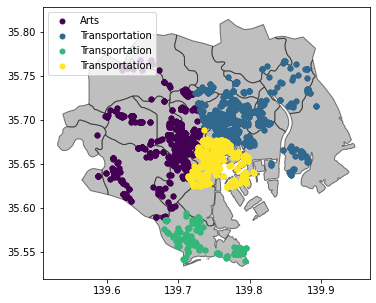

In [ ]:
Entrada = venues_city.iloc[:, 0:4].values

#ny.plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')
tk.iloc[t,:].plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')

classifica = ['Arts', 'Transportation', 'Transportation', 'Transportation']
color = ['#440154', '#31688e', '#35b779', '#fde725']
for i in range(0,4):
    #print(labels_city[i])
  plt.scatter(Entrada[labels_city == i, 1], Entrada[labels_city == i, 0], s = 25, c = color[i], label = classifica[i])
#Plotting the centroids of the clusters
plt.legend(loc="upper left")

In [ ]:
### DINING AND DRINKING ###
count = []
for i in range(0,nclusters):
  x = cp_venues[cp_venues['k-means'] == i]
  x = x[x['classification'] == 3.0]
  for k in x['categorie']: count.append(dining_dict[k])
  print('\n\K-MEANS')
  print(pd.Series(count).value_counts())
  print('\n')


\K-MEANS
Restaurant                       178
Bar                              101
Cafes, Coffee, and Tea Houses     49
Bakery                            14
Dessert Shop                      12
Smoothie Shop                      4
Food Court                         4
Juice Bar                          2
Distillery                         1
Breakfast Spot                     1
dtype: int64



\K-MEANS
Restaurant                       202
Bar                              105
Cafes, Coffee, and Tea Houses     54
Bakery                            15
Dessert Shop                      13
Smoothie Shop                      4
Food Court                         4
Juice Bar                          2
Bagel Shop                         2
Distillery                         1
Breakfast Spot                     1
dtype: int64



\K-MEANS
Restaurant                       210
Bar                              107
Cafes, Coffee, and Tea Houses     57
Bakery                            15
Dessert Shop   

## Temporal analysis

### Weekdays

In [ ]:
cp_venues = df
cp_venues['k-means'] = venues_city['k-means']

cp_venues = cp_venues.dropna()
cp_venues.reset_index(drop=True)
cp_venues.shape

(17304, 14)

In [ ]:
for i in range(0,nclusters):
  #print(f'\nCLUSTER {i} -> weekday')
  maximum = []
  for j in range(0,10):
    x = cp_venues[cp_venues['k-means'] == i]
    x = x[x['weekday'] == 1]
    maximum.append(x[x['classification'] == j].shape[0])
    #print(f'{classification[j]} -> ' + str(maximum[j]))
  print(f'Cluster ({i}) k-means weekday -> {classification[maximum.index(max(maximum))]}\t{x.shape}')

  #print(f'\nCLUSTER {i} -> weekend')
  maximum = []
  for j in range(0,10):
    x = cp_venues[cp_venues['k-means'] == i]
    x = x[x['weekday'] == 0]
    maximum.append(x[x['classification'] == j].shape[0])
    #print(f'{classification[j]} -> ' + str(maximum[j]))
  print(f'Cluster ({i}) k-means weekend -> {classification[maximum.index(max(maximum))]}\t{x.shape}\n\n')

Cluster (0) k-means weekday -> Travel and Transportation	(426, 14)
Cluster (0) k-means weekend -> Arts and Entertainment	(4476, 14)


Cluster (1) k-means weekday -> Travel and Transportation	(712, 14)
Cluster (1) k-means weekend -> Dining and Drinking	(6730, 14)


Cluster (2) k-means weekday -> Travel and Transportation	(154, 14)
Cluster (2) k-means weekend -> Travel and Transportation	(1438, 14)


Cluster (3) k-means weekday -> Travel and Transportation	(344, 14)
Cluster (3) k-means weekend -> Travel and Transportation	(3024, 14)




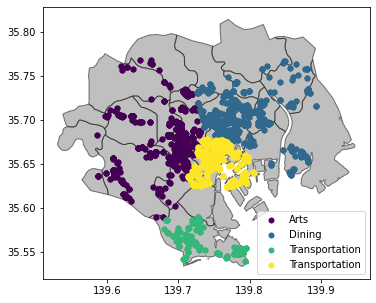

In [ ]:
Entrada = cp_venues[cp_venues['weekday'] == 0].iloc[:,[7,8,13]]
labels_city_time = cp_venues[cp_venues['weekday'] == 0].iloc[:,[7,8,13]]


#ny.plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')
tk.iloc[t,:].plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')

classifica = ['Arts', 'Dining', 'Transportation', 'Transportation']
color = ['#440154', '#31688e', '#35b779', '#fde725']
for i in range(0,4):
    #print(labels_city[i])
  plt.scatter(Entrada[labels_city_time['k-means'] == i].iloc[:,1], Entrada[labels_city_time['k-means'] == i].iloc[:,0], s = 25, c = color[i], label = classifica[i])
#Plotting the centroids of the clusters
plt.legend(loc="lower right")

In [ ]:
# MONTAR GRÁFICOS PARA MELHORAR A VISUALIZAÇÃO DOS RESULTADOS
#np.unique(np.array(list(dining_dict.values())))

In [ ]:
### DINING AND DRINKING ###
for i in range(0,nclusters):
  count = []
  x = cp_venues[cp_venues['k-means'] == i]
  x = x[x['weekday'] == 1]
  x = x[x['classification'] == 3.0]
  for k in x['categorie']:
    count.append(dining_dict[k])
  print(f'CLUSTER {i} -> weekday\t{x.shape}')
  if len(count) > 0: print(pd.Series(count).value_counts())
  else: print('There\'s no Dining and Drinking')
  print()

  count = []

  x = cp_venues[cp_venues['k-means'] == i]
  x = x[x['weekday'] == 0]
  x = x[x['classification'] == 3.0]
  for k in x['categorie']:
    count.append(dining_dict[k])
  print(f'CLUSTER {i} -> weekend\t{x.shape}')
  if len(count) > 0: print(pd.Series(count).value_counts())
  else: print('There\'s no Dining and Drinking')
  print()

CLUSTER 0 -> weekday	(178, 14)
Restaurant                       92
Bar                              48
Cafes, Coffee, and Tea Houses    25
Dessert Shop                      5
Bakery                            5
Distillery                        1
Breakfast Spot                    1
Juice Bar                         1
dtype: int64

CLUSTER 0 -> weekend	(188, 14)
Restaurant                       86
Bar                              53
Cafes, Coffee, and Tea Houses    24
Bakery                            9
Dessert Shop                      7
Smoothie Shop                     4
Food Court                        4
Juice Bar                         1
dtype: int64

CLUSTER 1 -> weekday	(15, 14)
Restaurant                       11
Cafes, Coffee, and Tea Houses     3
Bakery                            1
dtype: int64

CLUSTER 1 -> weekend	(22, 14)
Restaurant                       13
Bar                               4
Bagel Shop                        2
Cafes, Coffee, and Tea Houses     2
Dessert 

### Time interval

In [ ]:
cp_venues = df
cp_venues['k-means'] = venues_city['k-means']

cp_venues = cp_venues.dropna()
cp_venues.reset_index(drop=True)
cp_venues.shape

(1916, 14)

In [ ]:
for i in range(0,nclusters):
  #print(f'\nCLUSTER {i} -> time: 0')
  maximum = []
  for j in range(0,10):
    x = cp_venues[cp_venues['k-means'] == i]
    x = x[x['time'] == 0]
    maximum.append(x[x['classification'] == j].shape[0])

    #print(f'{classification[j]} -> ' + str(maximum[j]))
  print(f'Cluster {i} K-Means \t 00:00 until 05:59 \t {classification[maximum.index(max(maximum))]}\t{x.shape}')

  #print(f'\nCLUSTER {i} \t time: 1')
  maximum = []
  for j in range(0,10):
    x = cp_venues[cp_venues['k-means'] == i]
    x = x[x['time'] == 1]
    maximum.append(x[x['classification'] == j].shape[0])

    #print(f'{classification[j]} \t ' + str(maximum[j]))
  print(f'Cluster {i} K-Means\t 06:00 until 11:59 \t {classification[maximum.index(max(maximum))]}\t{x.shape}')

  #print(f'\nCLUSTER {i} \t time: 2')
  maximum = []
  for j in range(0,10):
    x = cp_venues[cp_venues['k-means'] == i]
    x = x[x['time'] == 2]
    maximum.append(x[x['classification'] == j].shape[0])

  print(f'Cluster {i} K-Means\t 12:00 until 17:59 \t {classification[maximum.index(max(maximum))]}\t{x.shape}')
    #print(f'{classification[j]} \t ' + str(maximum[j]))

  #print(f'\nCLUSTER {i} \t time: 3')
  maximum = []
  for j in range(0,10):
    x = cp_venues[cp_venues['k-means'] == i]
    x = x[x['time'] == 3]
    maximum.append(x[x['classification'] == j].shape[0])

    #print(f'{classification[j]} \t ' + str(maximum[j]))
  print(f'Cluster {i} K-Means\t 18:00 until 23:59 \t {classification[maximum.index(max(maximum))]}\t{x.shape}\n\n')

Cluster 0 K-Means 	 00:00 until 05:59 	 Dining and Drinking	(48, 14)
Cluster 0 K-Means	 06:00 until 11:59 	 Travel and Transportation	(138, 14)
Cluster 0 K-Means	 12:00 until 17:59 	 Dining and Drinking	(306, 14)
Cluster 0 K-Means	 18:00 until 23:59 	 Dining and Drinking	(274, 14)


Cluster 1 K-Means 	 00:00 until 05:59 	 Landmarks and Outdoors	(25, 14)
Cluster 1 K-Means	 06:00 until 11:59 	 Landmarks and Outdoors	(74, 14)
Cluster 1 K-Means	 12:00 until 17:59 	 Dining and Drinking	(42, 14)
Cluster 1 K-Means	 18:00 until 23:59 	 Dining and Drinking	(39, 14)


Cluster 2 K-Means 	 00:00 until 05:59 	 Arts and Entertainment	(0, 14)
Cluster 2 K-Means	 06:00 until 11:59 	 Dining and Drinking	(4, 14)
Cluster 2 K-Means	 12:00 until 17:59 	 Dining and Drinking	(8, 14)
Cluster 2 K-Means	 18:00 until 23:59 	 Dining and Drinking	(15, 14)


Cluster 3 K-Means 	 00:00 until 05:59 	 Travel and Transportation	(51, 14)
Cluster 3 K-Means	 06:00 until 11:59 	 Travel and Transportation	(199, 14)
Cluster 3 

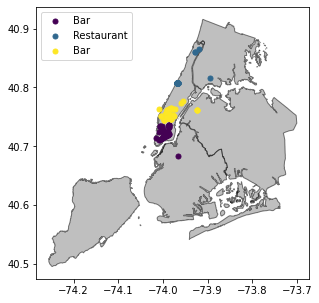

In [ ]:
#Entrada = cp_venues[(cp_venues['time'] == 2) | (cp_venues['time'] == 3)].iloc[:,[7,8,13]]
#labels_city_time = cp_venues[(cp_venues['time'] == 2) | (cp_venues['time'] == 3)].iloc[:,[7,8,13]]
Entrada = cp_venues[(cp_venues['time'] == 0)].iloc[:,[7,8,13]]
labels_city_time = cp_venues[(cp_venues['time'] == 0)].iloc[:,[7,8,13]]


ny.plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')
#tk.iloc[t,:].plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')

classifica = ['Bar', 'Restaurant', '-', 'Bar']
color = ['#440154', '#31688e', '#35b779', '#fde725']
plt.scatter(Entrada[labels_city_time['k-means'] == 0].iloc[:,1], Entrada[labels_city_time['k-means'] == 0].iloc[:,0], s = 25, c = color[0], label = classifica[0])
plt.scatter(Entrada[labels_city_time['k-means'] == 1].iloc[:,1], Entrada[labels_city_time['k-means'] == 1].iloc[:,0], s = 25, c = color[1], label = classifica[1])
#plt.scatter(Entrada[labels_city_time['k-means'] == 2].iloc[:,1], Entrada[labels_city_time['k-means'] == 2].iloc[:,0], s = 25, c = color[2], label = classifica[2])
plt.scatter(Entrada[labels_city_time['k-means'] == 3].iloc[:,1], Entrada[labels_city_time['k-means'] == 3].iloc[:,0], s = 25, c = color[3], label = classifica[3])
#Plotting the centroids of the clusters
plt.legend(loc="upper left")

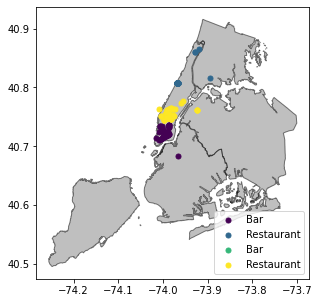

In [ ]:
#Entrada = cp_venues[(cp_venues['time'] == 2) | (cp_venues['time'] == 3)].iloc[:,[7,8,13]]
#labels_city_time = cp_venues[(cp_venues['time'] == 2) | (cp_venues['time'] == 3)].iloc[:,[7,8,13]]
Entrada = cp_venues[(cp_venues['time'] == 0)].iloc[:,[7,8,13]]
labels_city_time = cp_venues[(cp_venues['time'] == 0)].iloc[:,[7,8,13]]


ny.plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')
#tk.iloc[t,:].plot(figsize=(6,5), color='gray', alpha=0.5, edgecolor='black')

classifica = ['Bar', 'Restaurant', 'Bar', 'Restaurant']
color = ['#440154', '#31688e', '#35b779', '#fde725']
for i in range(0,4):
    #print(labels_city[i])
  plt.scatter(Entrada[labels_city_time['k-means'] == i].iloc[:,1], Entrada[labels_city_time['k-means'] == i].iloc[:,0], s = 25, c = color[i], label = classifica[i])
#Plotting the centroids of the clusters
plt.legend(loc="lower right")

In [ ]:
### DINING AND DRINKING ###
for i in range(0,nclusters):
  ### TIME 0
  count = []
  x = cp_venues[cp_venues['k-means'] == i]
  x = x[x['time'] == 0]
  x = x[x['classification'] == 3.0]
  for k in x['categorie']: count.append(dining_dict[k])
  print(f'CLUSTER {i} \t 00:00 until 05:59\t{x.shape}')
  if len(count) > 0: print(pd.Series(count).value_counts())
  else: print('There\'s no Dining and Drinking')
  print()

  ### TIME 1
  count = []
  x = cp_venues[cp_venues['k-means'] == i]
  x = x[x['time'] == 1]
  x = x[x['classification'] == 3.0]
  for k in x['categorie']: count.append(dining_dict[k])
  print(f'CLUSTER {i} \t 06:00 until 11:59\t{x.shape}')
  if len(count) > 0: print(pd.Series(count).value_counts())
  else: print('There\'s no Dining and Drinking')
  print()

  ### TIME 2
  count = []
  x = cp_venues[cp_venues['k-means'] == i]
  x = x[x['time'] == 2]
  x = x[x['classification'] == 3.0]
  for k in x['categorie']: count.append(dining_dict[k])
  print(f'CLUSTER {i} \t 12:00 until 17:59\t{x.shape}')
  if len(count) > 0: print(pd.Series(count).value_counts())
  else: print('There\'s no Dining and Drinking')
  print()

  ### TIME 3
  count = []
  x = cp_venues[cp_venues['k-means'] == i]
  x = x[x['time'] == 3]
  x = x[x['classification'] == 3.0]
  for k in x['categorie']: count.append(dining_dict[k])
  print(f'CLUSTER {i} \t 18:00 until 23:59\t{x.shape}')
  if len(count) > 0: print(pd.Series(count).value_counts())
  else: print('There\'s no Dining and Drinking')
  print()

CLUSTER 0 	 00:00 until 05:59	(31, 14)
Bar           24
Restaurant     7
dtype: int64

CLUSTER 0 	 06:00 until 11:59	(35, 14)
Restaurant                       13
Cafes, Coffee, and Tea Houses    10
Bar                               6
Smoothie Shop                     4
Bakery                            2
dtype: int64

CLUSTER 0 	 12:00 until 17:59	(132, 14)
Restaurant                       70
Cafes, Coffee, and Tea Houses    31
Bar                              11
Dessert Shop                      7
Bakery                            6
Food Court                        4
Juice Bar                         2
Breakfast Spot                    1
dtype: int64

CLUSTER 0 	 18:00 until 23:59	(168, 14)
Restaurant                       88
Bar                              60
Cafes, Coffee, and Tea Houses     8
Bakery                            6
Dessert Shop                      5
Distillery                        1
dtype: int64

CLUSTER 1 	 00:00 until 05:59	(1, 14)
Restaurant    1
dtype: int64



# Distance between 2 geolocations

In [ ]:
import geopy.distance

coords_1 = (34.0522, -118.2436)
coords_2 = (35.685, 139.7514)

print(round(geopy.distance.geodesic(coords_1, coords_2).km, 4))

8830.3803


# Heatmaps

## Heatmap - Geral

In [ ]:
'''lat = df.latitude.tolist()
lng = df.longitude.tolist()
m = folium.Map(
    location=[0, 0],
    zoom_start=2
)
HeatMap(list(zip(lat, lng))).add_to(m)
m'''

'lat = df.latitude.tolist()\nlng = df.longitude.tolist()\nm = folium.Map(\n    location=[0, 0],\n    zoom_start=2\n)\nHeatMap(list(zip(lat, lng))).add_to(m)\nm'

## Heatmap - TOP 5 - Países
### Japan (JP), United States (US), Malaysia (MY), Thailand (TH), Turkey (TR)

In [ ]:
'''t5_country = df.loc[df['city'].isin(["New York", 'Tokyo'])]
lat = t5_country.latitude.tolist()
lng = t5_country.longitude.tolist()
c = folium.Map(
    location=[0, 0],
    zoom_start=2
)
HeatMap(list(zip(lat, lng))).add_to(c)
c'''

't5_country = df.loc[df[\'city\'].isin(["New York", \'Tokyo\'])]\nlat = t5_country.latitude.tolist()\nlng = t5_country.longitude.tolist()\nc = folium.Map(\n    location=[0, 0],\n    zoom_start=2\n)\nHeatMap(list(zip(lat, lng))).add_to(c)\nc'

## Heatmap - TOP 5 Categorias
### Rail Station, Ramen Restaurant, Rest Area, Convenience Store, Shopping Mall

In [ ]:
t5_country = df.loc[df['categorie'].isin(["Rail Station", "Ramen Restaurant ", "Rest Area", "Convenience Store", "Shopping Mall"])]
lat = t5_country.latitude.tolist()
lng = t5_country.longitude.tolist()
c = folium.Map(
    location=[0, 0],
    zoom_start=2
)
HeatMap(list(zip(lat, lng))).add_to(c)
c

## Heatmap - Alcohol Categories

In [ ]:
'''alc = df.loc[df['categorie'].isin(alcohol)]
lat = alc.latitude.tolist()
lng = alc.longitude.tolist()
c = folium.Map(
    location=[0, 0],
    zoom_start=2
)
HeatMap(list(zip(lat, lng))).add_to(c)
c'''

"alc = df.loc[df['categorie'].isin(alcohol)]\nlat = alc.latitude.tolist()\nlng = alc.longitude.tolist()\nc = folium.Map(\n    location=[0, 0],\n    zoom_start=2\n)\nHeatMap(list(zip(lat, lng))).add_to(c)\nc"

In [ ]:
'''df_marker = alc[['latitude','longitude']]
df_pop = alc[['name']]
loc_list = df_marker.values.tolist()
pop_list = df_pop.values.tolist()

c = folium.Map(
    location=[0, 0],
    zoom_start=2
)

for i in range(0, len(loc_list)):
    folium.Marker(loc_list[i], popup=pop_list[i]).add_to(c)

for i in zip(lat,lng):
    folium.Marker(i).add_to(c)
c'''

"df_marker = alc[['latitude','longitude']]\ndf_pop = alc[['name']]\nloc_list = df_marker.values.tolist()\npop_list = df_pop.values.tolist()\n\nc = folium.Map(\n    location=[0, 0],\n    zoom_start=2\n)\n\nfor i in range(0, len(loc_list)):\n    folium.Marker(loc_list[i], popup=pop_list[i]).add_to(c)\n\nfor i in zip(lat,lng):\n    folium.Marker(i).add_to(c)\nc"

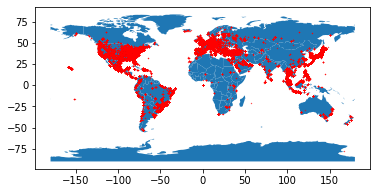

In [ ]:
###ÚTIL PARA MOSTRAR MAPA GERAL DE VENUES###

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot()

plt.scatter(df['longitude'].values,df['latitude'].values,c='red', s=0.1)

plt.show()